# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [25]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, LeaveOneGroupOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import decoupler as dc
import seaborn as sns
import json
# import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import csr_matrix
from venn import venn

%matplotlib inline

surragate_names = {'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
                   'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
                   'figr':'FigR', 'figr_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'granie':'GRANIE',
                   'ananse':'ANANSE',
                   'scglue':'scGLUE',
                   'positive_control':'Positive Control',
                   'negative_control':'Negative Control',
                   'pearson':'Pearson',
                   'SL':'SLA'
                   }


work_dir = '../output'
os.makedirs(f'{work_dir}', exist_ok=True)
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = dc.get_collectri(organism='human', split_complexes=False)
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


# Topological analysis 

In [35]:
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmarking/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

### Regulatory links

In [8]:
links_n = {}
for name, grn in grn_models_dict.items():
    if 'cell_type' in grn.columns: # for cell specific grn models, take the mean
        n_grn = grn.groupby('cell_type').size().mean()
    else:
        n_grn = len(grn)
    links_n[name] = n_grn
print(links_n)

{'FigR': 24292, 'CellOracle': 50000.0, 'GRANIE': 10679, 'ANANSE': 50000, 'scGLUE': 51567, 'Scenic+': 33537}


### Regulatory effect

In [9]:
regulatory_effect_dict = {}
for name, grn in grn_models_dict.items():
    print('-----', name)
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    if 'cell_type' in grn.columns:
        celltype_counts = grn_sign.groupby('cell_type').weight.value_counts()
        signs = [celltype_counts[celltype_counts.index.get_level_values('weight')==1].mean(), celltype_counts[celltype_counts.index.get_level_values('weight')==-1].mean()]
    else:
        signs = grn_sign.weight.value_counts().values # 'positive, negative:
    if len(signs)==1:
        signs = [signs[0], 0]
    regulatory_effect_dict[name] = signs
regulatory_effect_dict

----- FigR
----- CellOracle
----- GRANIE
----- ANANSE
----- scGLUE
----- Scenic+


{'FigR': array([13952, 10340]),
 'CellOracle': [31621.25, 18378.75],
 'GRANIE': array([9340, 1339]),
 'ANANSE': [50000, 0],
 'scGLUE': [51567, 0],
 'Scenic+': array([33102,   435])}

### TFs and target genes

In [10]:
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()

In [11]:
print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

number of TFs
{'FigR': 389, 'CellOracle': 549, 'GRANIE': 180, 'ANANSE': 77, 'scGLUE': 439, 'Scenic+': 140}
number of targets


{'FigR': 7804,
 'CellOracle': 8597,
 'GRANIE': 6548,
 'ANANSE': 2859,
 'scGLUE': 11450,
 'Scenic+': 10789}

### DORCS

In [12]:
CRE_target_df_dict = {}
for name in peak_gene_model:
    model = pd.read_csv(f'../output/benchmarking/peak_gene_models/{name}.csv', index_col=0)
    model.peak = model.peak.str.replace('_','-')
    model.peak = model.peak.str.replace(':','-')
    CRE_target_df_dict[name] = model

In [13]:
CRE_target_df_dict = {surragate_names[name]:grn for name, grn in CRE_target_df_dict.items()}

In [14]:
peaks_dict = {}
peaks_n_dict = {}
for name, df in CRE_target_df_dict.items():
    peaks_dict[name] = df.peak.unique()
    peaks_n_dict[name] = df.peak.unique().shape[0]

In [15]:
# multiple thresholds 
dorcs_n_dict = {}
thresholds_dorcs = range(5, 20)
for name, df in CRE_target_df_dict.items():
    stack_ = []
    for t in thresholds_dorcs:
        stack_.append((df.groupby('target').size()>=t).sum())
    dorcs_n_dict[name] = stack_

### Master TFs

In [16]:
# range of thresholds 
thresholds_master_TFs = range(100, 5000, 10)
master_tfs_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_master_TFs:
        size_ = grn.groupby('source').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    master_tfs_n_dict[name] = stack_


### In-degree for target genes

In [17]:
thresholds_indegree = range(5,20,1)
indegree_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_indegree:
        size_ = grn.groupby('target').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    indegree_n_dict[name] = stack_



### Plot number of GRN elements 

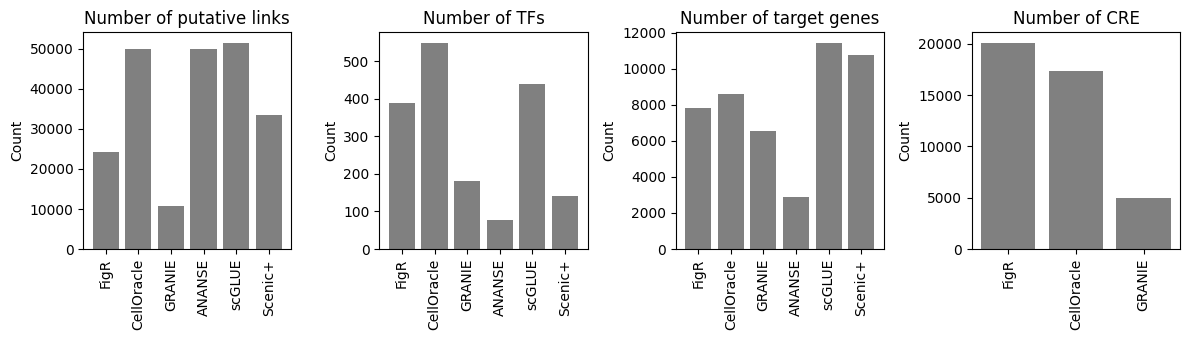

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3.5)) 
color = 'grey'
## number of links
ax = axes[0]
ax.bar(links_n.keys(), links_n.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of putative links')
# ax.set_yscale('log')

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[1]
ax.bar(tfs_dict_n.keys(), tfs_dict_n.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of TFs')
# ax.set_yscale('log')
## number of target 
ax = axes[2]

ax.bar(target_genes_dict_n.keys(), target_genes_dict_n.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of target genes')
# ax.set_yscale('log')
plt.tight_layout()

## number of peaks 
ax = axes[3]
ax.bar(peaks_n_dict.keys(), peaks_n_dict.values(), color=color)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of CRE')
# ax.set_yscale('log')
plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/stats_regulatory_elements.png', dpi=150, transparent=True)

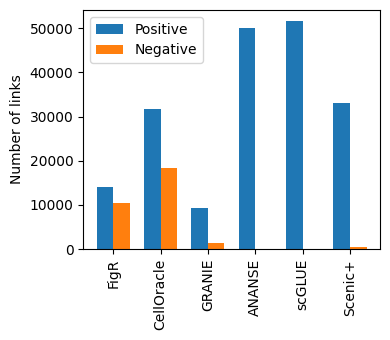

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5)) 
# regulatory role 
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive')
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative')
ax.set_ylabel('Number of links')
# ax.set_title('Regulatory sign')
ax.set_xticks(x)
ax.set_xticklabels(categories)
# ax.set_xticklabels([category for category in categories])
ax.tick_params(axis='x', rotation=90)
# ax.set_yscale('log')
ax.legend()
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/regulatory_signs.png', dpi=150, transparent=True)

### Plot intersection of GRN elements
venn diagram

In [20]:
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link'].drop_duplicates().reset_index(drop=True)

### upsetplot of GRN elements

 ####### Links
 ####### target genes
 ####### TFs
 ####### CRE


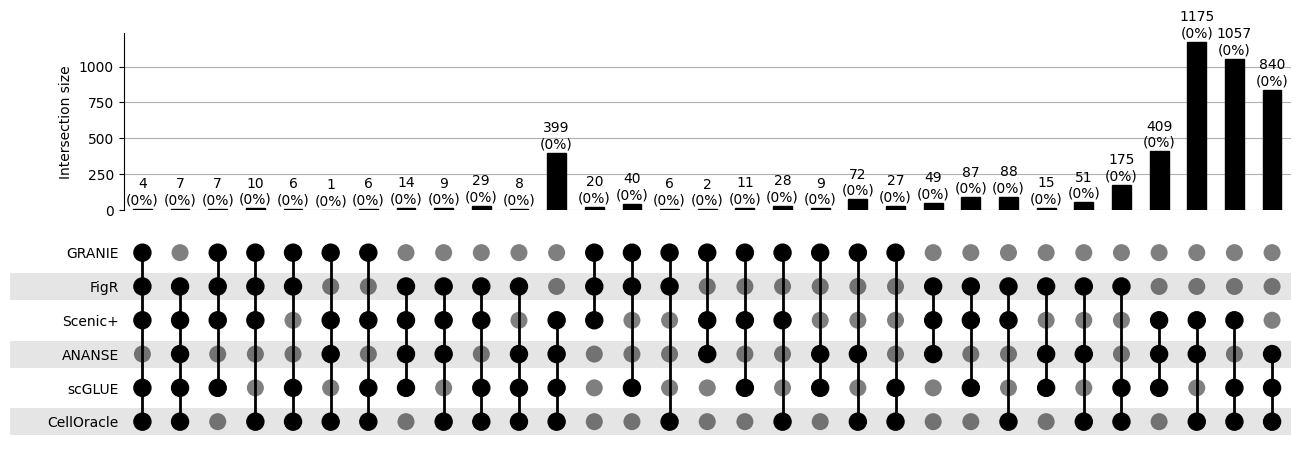

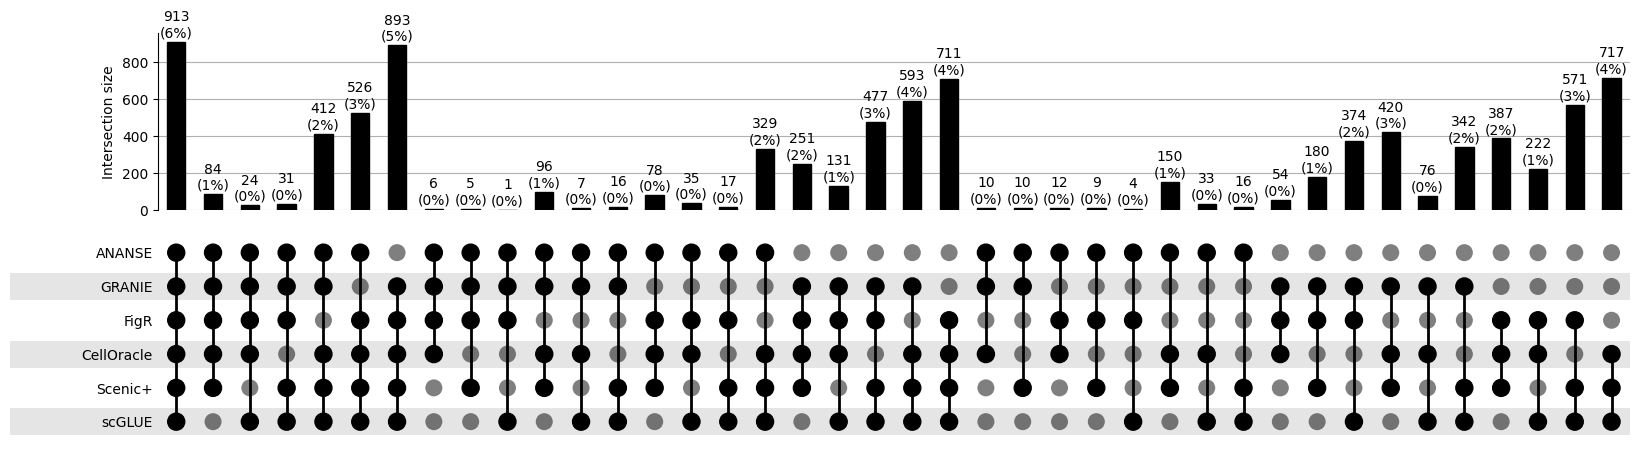

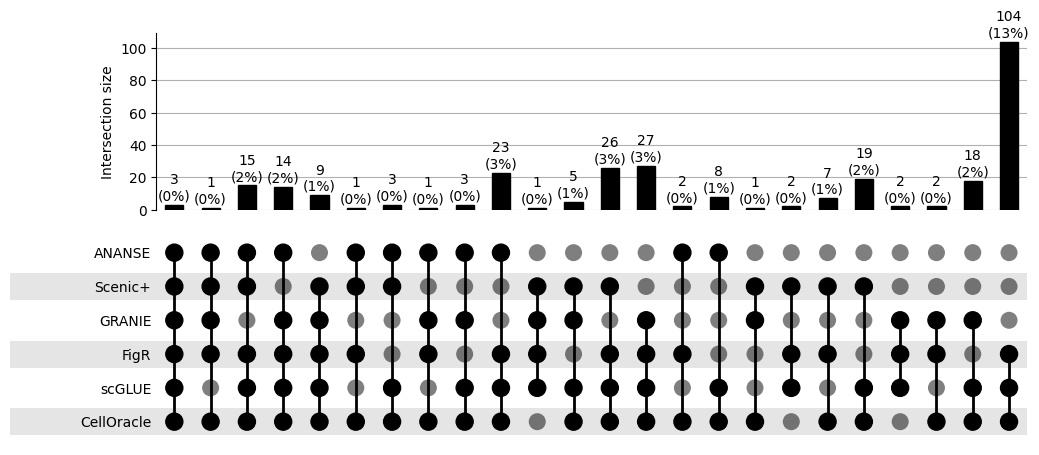

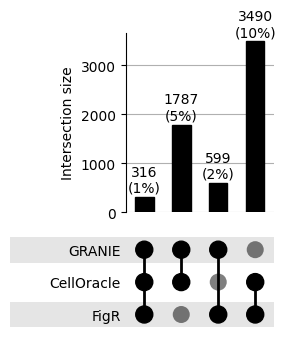

In [21]:
from upsetplot import from_indicators, plot
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")
# Create a set of all unique genes
def convert_df(data):
    all_genes = list(set(gene for genes in data.values() for gene in genes))
    # Initialize DataFrame
    df = pd.DataFrame(index=all_genes)
    # Populate DataFrame
    for key, genes in data.items():
        df[key] = df.index.isin(genes)
    return df


print(' ####### Links')
fig = plt.figure()
df_interactions = convert_df(grn_fused_dict)    
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions),fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35, #side length
        intersection_plot_elements=5,
        totals_plot_elements = 0)
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/links_interactions.png', dpi=150, transparent=True)

print(' ####### target genes')
fig = plt.figure()
df_interactions = convert_df(target_genes_dict)    
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0)
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/targets_interactions.png', dpi=150, transparent=True)


print(' ####### TFs')
fig = plt.figure()
df_interactions = convert_df(tfs_dict)
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0
        )
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/TFs_interactions.png', dpi=150, transparent=True)

print(' ####### CRE')
fig = plt.figure()
df_interactions = convert_df(peaks_dict)
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree',  #-cardinality
        # min_subset_size =100, 
        min_degree=2,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0
        )
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
#     fig.savefig(f'{work_dir}/benchmark/figs/CRE_interactions.png', dpi=150, transparent=True)

### Plot connectivity (DORCs, master TFs, etc)

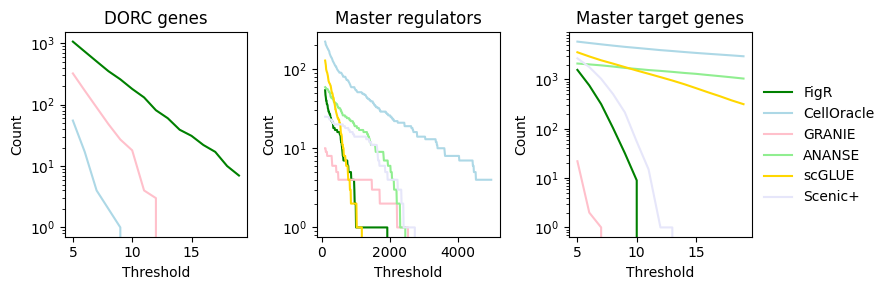

In [26]:
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

fig, axes = plt.subplots(1, 3, figsize=(9, 3)) 
def plot_lines(ax, data, x_range, title):
    for i, key in enumerate(data):
        ax.plot(x_range, data[key], label=key, color=colors_light[i])
        # ax.plot(x_range, data[key], label=key, color=colors_light[i])
    # ax.set_xticks(x_range)
    # ax.set_xticklabels(thresholds_indegree)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_yscale('log')
## DORCs
plot_lines(axes[0], dorcs_n_dict, thresholds_dorcs, 'DORC genes')

## master TFs
plot_lines(axes[1], master_tfs_n_dict, thresholds_master_TFs, 'Master regulators')

## in degree for target genes 
plot_lines(axes[2], indegree_n_dict, thresholds_indegree, 'Master target genes')

axes[-1].legend(loc='upper left', bbox_to_anchor=(1,.8), frameon=False)
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/connectivity.png', dpi=150, transparent=True)

## Types of peaks

In [ ]:
%load_ext rpy2.ipython

In [ ]:
temp_dir = f'{work_dir}/benchmark/temp/peak_annotation/'
os.makedirs(temp_dir)
for name, grn_ct in CRE_target_df_dict.items():
    peaks = grn_ct.peak.str.split('-', n=1, expand=True)
    peaks.columns = ['chr','range']
    peaks.to_csv(f'{temp_dir}{name}.txt', index=False)
method_names = list(CRE_target_df_dict.keys())

FileExistsError: [Errno 17] File exists: '../output/benchmark/temp/peak_annotation/'

In [ ]:
%%R -i method_names -i temp_dir
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)


library(IRanges)
library(GenomicRanges)
library(ggplot2)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

for (name in method_names){
  peaks = read.table(paste0(temp_dir, name, '.txt'), sep=',', header = TRUE)
  peaks = GRanges(peaks$chr, IRanges(peaks$range))
  peaks_annotated = suppressMessages(ChIPseeker::annotatePeak(
      peaks,
      tssRegion = c(-1000, 1000), # extended from -5kb to 5
      TxDb = txdb,
      level = "transcript", 
      assignGenomicAnnotation = TRUE,  # the default
      genomicAnnotationPriority = c("Promoter", "5UTR", "3UTR", "Exon", "Intron",
                                    "Downstream", "Intergenic"),  # the default
      annoDb = NULL,
      sameStrand = FALSE, # the default
      ignoreOverlap = FALSE, # the default
      ignoreUpstream = FALSE, # the default
      ignoreDownstream = FALSE, # the default
      overlap = "TSS", # the default
      verbose = TRUE # the default
    ))
  peaks_annotated_df = as.data.frame(peaks_annotated)
  write.table(peaks_annotated_df, paste0(temp_dir, name, '_annot.txt'), sep=',', row.names = FALSE)
}


>> preparing features information...		 2024-05-16 20:11:22 
>> identifying nearest features...		 2024-05-16 20:11:24 
>> calculating distance from peak to TSS...	 2024-05-16 20:11:25 
>> assigning genomic annotation...		 2024-05-16 20:11:25 
>> assigning chromosome lengths			 2024-05-16 20:11:50 
>> done...					 2024-05-16 20:11:50 
>> preparing features information...		 2024-05-16 20:11:51 
>> identifying nearest features...		 2024-05-16 20:11:51 
>> calculating distance from peak to TSS...	 2024-05-16 20:11:52 
>> assigning genomic annotation...		 2024-05-16 20:11:52 
>> assigning chromosome lengths			 2024-05-16 20:11:55 
>> done...					 2024-05-16 20:11:55 
>> preparing features information...		 2024-05-16 20:11:56 
>> identifying nearest features...		 2024-05-16 20:11:56 
>> calculating distance from peak to TSS...	 2024-05-16 20:11:56 
>> assigning genomic annotation...		 2024-05-16 20:11:56 
>> assigning chromosome lengths			 2024-05-16 20:12:00 
>> done...					 2024-05-16 20:12

Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors
Loading required package: stats4

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: GenomeInfoDb
Loading required package: GenomicFeatures
Loading required package: AnnotationDbi
Loading

In [ ]:
map_={'Intron':'Intron', 'Exon':'Exon', 'Promoter':'Promoter', 'Distal':'Distal Intergenic', "3'":"3' UTR", 'Downstream':'Downstream (<=300)', "5'":"5' UTR"}

annotation_dict = {}
for name in method_names:
    ann_df = pd.read_csv(f'{temp_dir}{name}_annot.txt')
    ann = ann_df.annotation.str.split(' ', expand=True)[0]
    ann = ann.map(map_)
    value_counts = ann.value_counts()
    sum_values = value_counts.sum()
    value_ratio = (value_counts/sum_values)*100
    annotation_dict[name] = value_ratio.to_dict()
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
# peak_annotation_df.index = peak_annotation_df.index.map(surragate_names)
peak_annotation_df

,Intron,Promoter,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
FigR,36.989504,30.980451,18.574342,6.605979,4.457046,1.552007
CellOracle,0.527868,98.782576,0.271067,0.199734,0.085600,0.009511
GRANIE,22.013844,55.891822,12.942692,4.370573,3.187379,1.150998


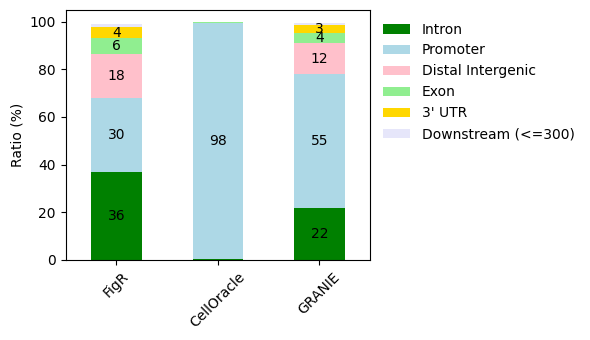

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax = peak_annotation_df.plot(kind='bar', stacked=True, ax=ax, rot=45, xlabel='', ylabel='Ratio (%)', color=colors_light)
for c in ax.containers:
    threshold = 2 # skip below this 
    labels = [int(v.get_height().round(2)) if v.get_height() > threshold else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# ax.set_title('CREs')
plt.tight_layout()
# fig.savefig(f'{work_dir}/benchmark/figs/annot_peaks.png', dpi=150, transparent=True)

# HVGs analysis


In [28]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

n_hvgs = 3000

### Highly devient genes: raw counts
Germain et al. instead proposes to use deviance for feature selection which works on raw counts [Germain et al., 2020]. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile across cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the binomial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e., they don’t show constant expression across cells).

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R -i work_dir
library(scry)
library(zellkonverter)
library(SingleCellExperiment)
options(digits=5, max.print=100)  # Adjust numbers as needed



adata = readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
sce = devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [29]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


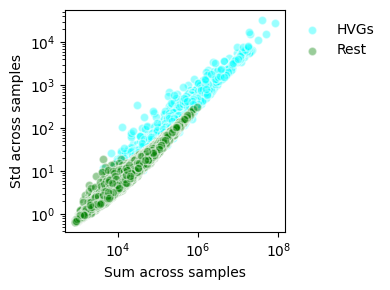

In [30]:
genes = hvgs_sce
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = bulk_adata_f.var
var['sum'] = bulk_adata_f.X.sum(axis=0)
var['std'] = bulk_adata_f.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')


ax.set_ylabel('Std across samples')
ax.set_xlabel('Sum across samples')
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)



### GRN targets vs HVGs 

In [31]:
genesets_dict = {**{name:grn.target.unique() for name, grn in grn_models_dict.items()}, **{'HKGs':housekeeping_genes}}

In [33]:
hvgs = hvgs_sce

hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {}
n_random = 100
for name, geneset in genesets_dict.items():
    pert_genes = bulk_adata_f.var_names
    shared_genes = np.intersect1d(geneset, pert_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(pert_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
hvgs_intersection_ratio_dict

{'FigR': 0.3111812593454062,
 'CellOracle': 0.30914826498422715,
 'GRANIE': 0.2857142857142857,
 'ANANSE': 0.512273212379936,
 'scGLUE': 0.32481376830208064,
 'Scenic+': 0.2808685319217889,
 'HKGs': 0.18445772843723313}

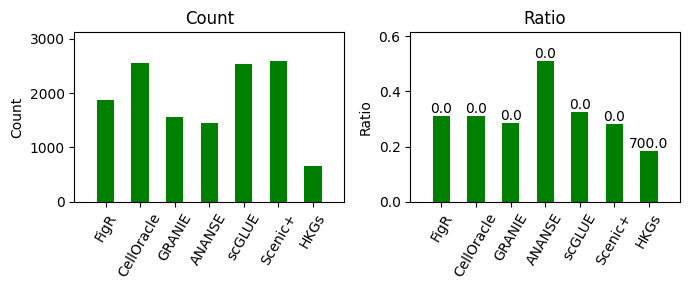

In [34]:
hvgs = hvgs_sce

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)


def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color=colors_light[0], label='SCRE')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(axes[0], hvgs_intersection_n_dict, y_label='Count', title='Count')
plot_bar(axes[1], hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

# axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

plt.tight_layout()
plt.show()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

# Multivariate 

In [3]:
norm_method = 'pearson'
df_train = pd.read_csv(f'../output/benchmarking/df_train/df_train_{norm_method}.csv').set_index(['sm_name','cell_type','plate_name','row'])

In [14]:
grn_model_names = ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmarking/grn_models/{name}.csv', index_col=0)
baselines = ['positive_control', 'negative_control']
for name in baselines:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmarking/baseline_models/{name}.csv', index_col=0)
# grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [41]:
from sklearn.metrics import mean_squared_error
import lightgbm
from sklearn.ensemble import GradientBoostingRegressor

class lightgbm_wrapper:
    def __init__(self, params):
        self.params =  params
        
    def fit_predict(self, X_train, Y_train, X_test):
        y_pred_list = []
        for i in range(Y_train.shape[1]):
            regr = lightgbm.LGBMRegressor(**self.params)
            regr.fit(X_train, Y_train[:, i])
            y_pred = regr.predict(X_test)
            y_pred_list.append(y_pred)
            
        return np.stack(y_pred_list, axis=1)
def cv_5(genes_n):
    '''5 fold standard'''
    num_groups = 5
    group_size = genes_n // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if genes_n % num_groups != 0:
        groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
    np.random.shuffle(groups)
    return groups

def run_multivariate_gb_regression(net: pd.DataFrame, 
            reg_type: str = 'GB', 
            params: dict = {}, 
            include_missing: bool = False,
            verbose: int = 0) -> None:     
    #
    df = df_train.copy()
    df = df.reset_index(level='cell_type').set_index('cell_type') 

    # determine regressor 
    if reg_type=='ridge':
        regr = Ridge(alpha=100)
    elif reg_type=='GB':
        regr = lightgbm_wrapper(params)
    else:
        raise ValueError("define first")

    # for each cell type
    cell_type_index = df.index
    Y_true_matrix_stack = []
    Y_pred_matrix_stack = []
    for cell_type in cell_type_index.unique():
        print('---- ', cell_type,' --------')
        # subset df for cell type 
        mask = cell_type_index==cell_type
        df_celltype = df[mask]

        # net is cell type dependent or not 
        if 'cell_type' in net:
            net_celltype = net[net.cell_type==cell_type]
        else:
            net_celltype = net.copy()
        # match net and df in terms of shared genes 
        net_genes = net_celltype.target.unique()
        shared_genes = np.intersect1d(net_genes, df.columns)
        net_celltype = net_celltype[net_celltype.target.isin(shared_genes)]

        # define X and Y 
        Y = df_celltype[shared_genes].values.T
        X = net_celltype.pivot(index='target', columns='source', values='weight').fillna(0).values
        if verbose >=2:
            print(f'X (genes, TFs): {X.shape}, Y (genes, samples): {Y.shape}')

        # fill random weights for the missing genes
        if include_missing==True:
            missing_genes = np.setdiff1d(df.columns, shared_genes)
            Y_missing = df_celltype[missing_genes].values.T
            tfs_n = net_celltype.source.unique().shape[0]
            
            sparsity = (X==0).sum()/X.size
            ratios = [sparsity, (1-sparsity)/2, (1-sparsity)/2]
            shape = (missing_genes.shape[0], tfs_n)
            X_random = np.random.choice([0, -1, 1], size=shape, p=ratios)
            X = np.concatenate([X, X_random], axis=0)
            Y = np.concatenate([Y, Y_missing], axis=0)
            print(f'X (genes, TFs): {X.shape}, Y (genes, samples): {Y.shape}')
        else:
            pass 
        
        if manipulate=='shuffled':
            X_f = X.flatten()
            np.random.shuffle(X_f)
            X = X_f.reshape(X.shape)
        elif manipulate=='signed':
            X[X>0]=1
            X[X<0]=-1
            
        # define cv scheme
        groups = cv_5(X.shape[0])

        # run cv 
        Y_pred_stack = []
        Y_true_stack = []
        unique_groups = np.unique(groups)
        
        for group in unique_groups:
            mask_va = groups==group
            mask_tr = ~mask_va

            X_tr, Y_tr = X[mask_tr,:], Y[mask_tr,:]
            X_va, Y_true = X[mask_va,:], Y[mask_va,:]

            if reg_type=='GB':
                Y_pred = regr.fit_predict(X_tr, Y_tr, X_va)
            else:
                regr.fit(X_tr, Y_tr)
                Y_pred = regr.predict(X_va)

            Y_pred_stack.append(Y_pred)
            Y_true_stack.append(Y_true)
        y_pred = np.concatenate(Y_pred_stack, axis=0)
        y_true = np.concatenate(Y_true_stack, axis=0)
        if verbose >= 1:
            score_r2  = r2_score(y_true, y_pred, multioutput='variance_weighted') #uniform_average', 'variance_weighted
            loss_mse  = mean_squared_error(y_true, y_pred)
            print(f'score_r2: ', score_r2, 'loss_mse: ', loss_mse)
        Y_true_matrix_stack.append(y_true)
        Y_pred_matrix_stack.append(y_pred)

    Y_true = np.concatenate(Y_true_matrix_stack, axis=1)
    Y_pred = np.concatenate(Y_pred_matrix_stack, axis=1)

    mean_score_r2 = r2_score(Y_true, Y_pred, multioutput='variance_weighted')
    gene_scores_r2 = r2_score(Y_true.T, Y_pred.T, multioutput='raw_values')

    mean_mse = mean_absolute_error(Y_true, Y_pred, multioutput='uniform_average')
    gene_mse = mean_absolute_error(Y_true.T, Y_pred.T, multioutput='raw_values')


    output = dict(mean_score_r2=mean_score_r2, gene_scores_r2=list(gene_scores_r2),
                mean_mse=mean_mse, gene_mse=list(gene_mse))

    return output

In [54]:
reg_type = 'GB'
manipulate = None #'signed', None 'shuffled'

os.makedirs(f'{work_dir}/benchmark/scores/{norm_method}/', exist_ok=True)

grn_model = 'positive_control'
net = grn_models_dict[grn_model]
# for grn_model, net in grn_models_dict.items():
print(grn_model)
if reg_type=='ridge':
    output = run_multivariate_gb_regression(net, include_missing=True, reg_type=reg_type)
else:
    output = run_multivariate_gb_regression(net, include_missing=True, reg_type=reg_type, 
        params = dict(random_state=32, n_estimators=100, min_samples_leaf=2, min_child_samples=1, feature_fraction=0.05, verbosity=-1))
with open(f'{work_dir}/benchmark/scores/{norm_method}/{grn_model}_{manipulate}.json', 'w') as f:
    json.dump(output, f)

positive_control
----  B cells  --------
X (genes, TFs): (15193, 1056), Y (genes, samples): (15193, 540)
X (genes, TFs): (15215, 1056), Y (genes, samples): (15215, 540)
----  Myeloid cells  --------
X (genes, TFs): (15193, 1056), Y (genes, samples): (15193, 538)
X (genes, TFs): (15215, 1056), Y (genes, samples): (15215, 538)
----  NK cells  --------
X (genes, TFs): (15193, 1056), Y (genes, samples): (15193, 546)
X (genes, TFs): (15215, 1056), Y (genes, samples): (15215, 546)
----  T cells  --------
X (genes, TFs): (15193, 1056), Y (genes, samples): (15193, 546)
X (genes, TFs): (15215, 1056), Y (genes, samples): (15215, 546)


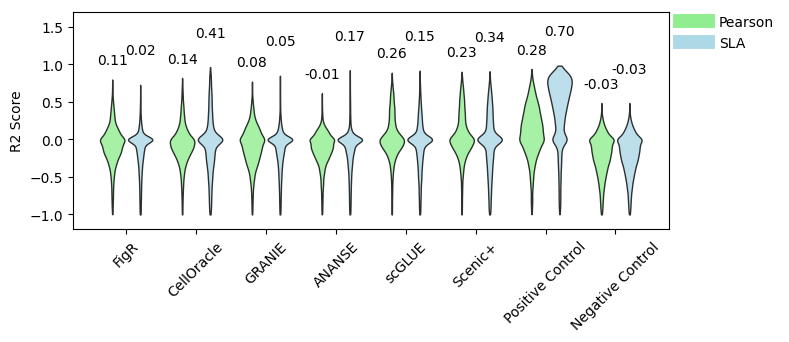

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5)) 
legend_colors = ['lightgreen', 'lightblue', 'orange']

offset = .4
widths = .35
score_lower_t = -1

handles = []  # To store legend handles
for i_plot, norm_method in enumerate(['pearson', 'SL']): 
    # --- read the scores
    model_names = []
    mean_score_list = []
    gene_scores_list = []
    sig_sign_list = []
    for grn_model in grn_models_dict.keys():
        file = f'{work_dir}/benchmark/scores/{norm_method}/{grn_model}_None.json'
        if not os.path.isfile(file):
            print(f'{file} doesnt exist')
            continue
        with open(file, 'r') as f:
            scores_dict = json.load(f)
            mean_score = scores_dict['mean_score_r2'] #mean_score_r2
            gene_scores = scores_dict['gene_scores_r2'] #gene_scores_r2
        gene_scores = np.asarray(gene_scores)
        model_names.append(grn_model)
        mean_score_list.append(mean_score)
        gene_scores_list.append(gene_scores)
    
    for i in range(len(gene_scores_list)):
        gene_scores = gene_scores_list[i]
        gene_scores[gene_scores < score_lower_t]= 0  # we dont want to see big negative numbers 
        gene_scores_list[i] = gene_scores

    # plot 
    color_group = legend_colors[i_plot]
    x_ticks = range(len(model_names))
    x_positions = [xx + (offset * (i_plot - 0.5)) for xx in x_ticks]

    violin_parts = ax.violinplot(gene_scores_list, positions=x_positions, 
                                showmeans=False, 
                                showmedians=False, 
                                showextrema=False,
                                widths=widths)
    
    for i, pc in enumerate(violin_parts['bodies']):
        color = color_group
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(.8)  # Ensuring the plot is fully opaque
        if surragate_names[norm_method] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
            if color == 'white':
                continue
            handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=surragate_names[norm_method]))
    keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
    for key in keys:
        if key in violin_parts:
            violin_parts[key].set_edgecolor('#C4C4C4')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([surragate_names[name] for name in model_names], rotation=45)
    ax.set_ylabel('R2 Score')
    ax.set_ylim([-1.2, 1.7])

    #-- annotate 
    y_positions = np.max(gene_scores_list, axis=1) + .2
    for ii, x_pos in enumerate(x_positions):
        y_pos = y_positions[ii] + .2 * i_plot
        txt = f'{mean_score_list[ii]:.2f}'
        ax.text(x_pos, y_pos, txt, ha='center', color='black')
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# # Correcting text annotations with offset adjustments

plt.tight_layout()
plt.show()

In [23]:
surragate_names.keys()

dict_keys(['collectRI', 'collectRI_sign', 'scenicplus', 'scenicplus_sign', 'celloracle', 'celloracle_sign', 'figr', 'figr_sign', 'baseline', 'cov_net', 'granie', 'ananse', 'scglue', 'positive_control', 'negative_control'])